In [3]:
from collections import defaultdict
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpimg
import numpy as np
import os
from skimage import exposure
from pybalu.feature_extraction import lbp_features, haralick_features, hog_features
import pickle
from pybalu.feature_transformation import normalize, pca

# Load images

Formato:

```
[
    [img_1_A, img_1_B],
    ...
]
```

In [36]:
def load_images(data_dir, data_size):
    img_names = sorted(os.listdir(data_dir))
    data = []
    sizes = defaultdict(int)
    for i in range(0, len(img_names), 2):
        tmp_data = []
        for j in range(2):
            img_path = os.path.join(data_dir, img_names[i + j])
            img = cv2.imread(img_path, 0)
            sizes[img.shape] += 1
            if img.shape != data_size:
                img = cv2.resize(img, data_size[:-1])
            tmp_data.append(img)
        data.append(tmp_data)
    print(sizes)
    return np.array(data)

In [3]:
TRAINING_DIR = '/home/chrisams/Datasets/patrones_project/training'
TESTING_DIR = '/home/chrisams/Datasets/patrones_project/testing'

In [4]:
X_train = load_images(TRAINING_DIR, (256, 256, 3))
X_test = load_images(TESTING_DIR, (256, 256, 3))

defaultdict(<class 'int'>, {(256, 256): 944})


In [5]:
X_train.shape, X_test.shape

NameError: name 'X_train' is not defined

# Testing loaded images

In [6]:
n = 0
test_a = X_train[n][0]
test_b = X_train[n][1]

# Denoise
test_a_denoise = cv2.fastNlMeansDenoising(test_a,None, 10, 10, 17)

# Equalization
test_a_eq = exposure.equalize_hist(test_a_denoise)
test_b_eq = exposure.equalize_hist(test_b)

plt.figure(figsize=(10,10))
plt.subplot(321),plt.imshow(test_a)
plt.subplot(322),plt.imshow(test_b)
plt.subplot(323),plt.imshow(test_a_eq)
plt.subplot(324),plt.imshow(test_b_eq)
plt.subplot(325),plt.imshow(test_a)
plt.subplot(326),plt.imshow(test_a_denoise)
plt.show()

NameError: name 'X_train' is not defined

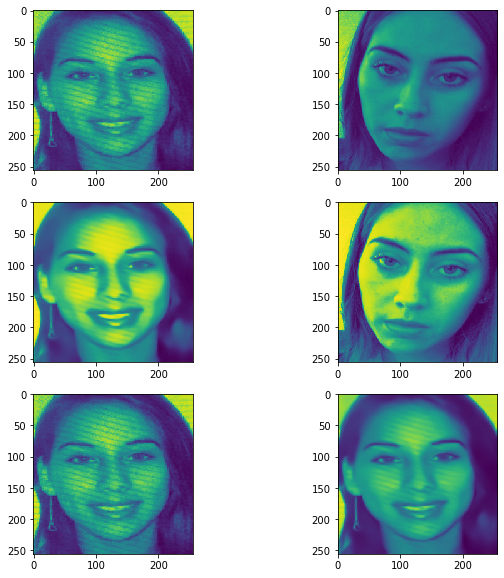

In [5]:
n = 5
test_a = X_test[n][0]
test_b = X_test[n][1]

#asda
test_a_denoise = cv2.fastNlMeansDenoising(test_a,None, 10, 10, 17)

# Equalization
test_a_eq = exposure.equalize_hist(test_a_denoise)
test_b_eq = exposure.equalize_hist(test_b)

plt.figure(figsize=(10,10))
plt.subplot(321),plt.imshow(test_a)
plt.subplot(322),plt.imshow(test_b)
plt.subplot(323),plt.imshow(test_a_eq)
plt.subplot(324),plt.imshow(test_b_eq)
plt.subplot(325),plt.imshow(test_a)
plt.subplot(326),plt.imshow(test_a_denoise)
plt.show()

# Data preprocessing

In [6]:
def preprocess_data(X, preprocess):
    new_data = []
    for i in range(X.shape[0]):
        img_a = X[i][0]
        img_b = X[i][1]
        for func in preprocess:
            img_a, img_b = func(img_a, img_b)
        new_data.append([img_a, img_b])
    return np.array(new_data)

In [7]:
preprocess = [
    lambda x, y: (cv2.fastNlMeansDenoising(x, None, 10, 10, 17), y),
    lambda x, y: (exposure.equalize_hist(x), exposure.equalize_hist(y)),
]

SAVE_DIR_TRAIN = '/home/chrisams/Datasets/patrones_project/training_preprocessed'
SAVE_DIR_TEST = '/home/chrisams/Datasets/patrones_project/test_preprocessed'

In [8]:
#X_train = preprocess_data(X_train, preprocess)
X_test = preprocess_data(X_test, preprocess)

In [13]:
X_train.shape, X_test.shape

NameError: name 'X_train' is not defined

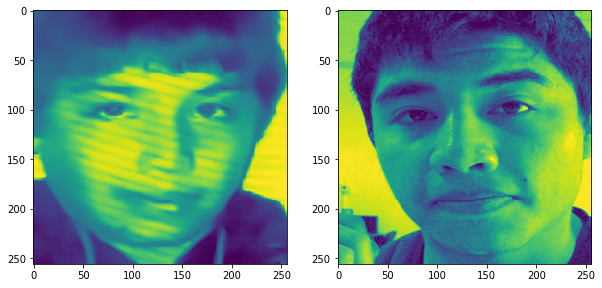

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(X_test[1][0])
plt.subplot(122),plt.imshow(X_test[1][1])
plt.show()

# Save preprocessed data

Así no se tiene que hacer todo el procedimiento de preprocesamiento a cada rato.

In [16]:
# with open('X_train_preprocessed.npy', 'wb') as f:
#     np.save(f, X_train)

In [12]:
# with open('X_test_preprocessed.npy', 'wb') as f:
#     np.save(f, X_test)

# Experiments with training data

In [4]:
with open('/home/chrisams/Datasets/patrones_project/X_train_preprocessed.npy', 'rb') as f:
    X = np.load(f)

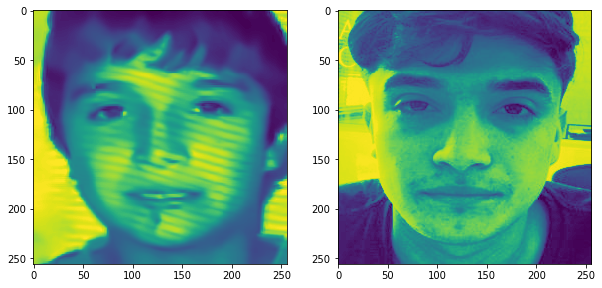

In [5]:
# Check loaded images.
plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(X[5][0])
plt.subplot(122),plt.imshow(X[5][1])
plt.show()

In [6]:
def get_features(X, funcs):
    data = []
    for i in range(X.shape[0]):
        img_a_feats = []
        img_b_feats = []
        for func in funcs:
            img_a_feats.append(func(X[i][0]))
            img_b_feats.append(func(X[i][1]))
        data.append([np.concatenate(img_a_feats), np.concatenate(img_b_feats)])
    return np.array(data)

def get_negative_examples(X, n):
    """n is the number of negative examples per image.
    """
    data = []
    N = len(X)
    choice_idxs = list(range(N))
    for i, (img_a, img_b) in enumerate(X):
        tmp_choice_idxs = choice_idxs.copy()
        tmp_choice_idxs.remove(i)
        negatives_idx = np.random.choice(tmp_choice_idxs, size=n, replace=False)
        for negative_idx in negatives_idx:
            negative_old = X[negative_idx][1]
            data.append([img_a, negative_old])
    return np.array(data)

In [7]:
# Features to extract.
funcs = [
    lambda x: lbp_features(x, hdiv=3, vdiv=3, mapping='nri_uniform'),
    lambda x: haralick_features(x),
    lambda x: hog_features(x, v_windows=3, h_windows=3, n_bins=8),
]

In [8]:
X_feats_pos = get_features(X, funcs)
X_feats_neg = get_negative_examples(X_feats_pos, 1)

In [9]:
X_feats_pos.shape, X_feats_neg.shape

((1750, 2, 631), (1750, 2, 631))

In [10]:
# Se juntan todas las features.
X_feats = np.concatenate([X_feats_pos, X_feats_neg])
X_feats.shape

(3500, 2, 631)

Se aplcia PCA por edad:

In [11]:
X_feats_young = X_feats[:, 0, :]
X_feats_old = X_feats[:, 1, :]
X_feats_young.shape, X_feats_old.shape

((3500, 631), (3500, 631))

In [55]:
X_feats_young_pca, _, A_young, Xm_young, _ = pca(X_feats_young, n_components=20)
X_feats_old_pca, _, A_old, Xm_old, _ = pca(X_feats_old, n_components=20)
X_feats_young_pca.shape, X_feats_old_pca.shape

((3500, 20), (3500, 20))

Se junta todo, viejos y jóvenes:

In [56]:
X_final = np.concatenate([X_feats_young_pca, X_feats_old_pca], axis=1)
X_final.shape

(3500, 40)

Bendita normalización:

In [57]:
X_final, a, b = normalize(X_final)

Se generan los labels:

In [58]:
y_pos = np.ones(X_feats_pos.shape[0])
y_neg = np.zeros(X_feats_neg.shape[0])
y = np.concatenate([y_pos, y_neg])
y, y.shape

(array([1., 1., 1., ..., 0., 0., 0.]), (3500,))

## Experimentos con MLP

In [59]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_final, y,
                                                    stratify=y, 
                                                    test_size=0.25,
                                                    shuffle=True)
clf = MLPClassifier(max_iter=1000, hidden_layer_sizes=(100,), learning_rate='adaptive')
clf.fit(X_train_b, y_train_b)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [60]:
y_pred_val = clf.predict(X_test_b)

In [61]:
print(classification_report(y_test_b, y_pred_val))

              precision    recall  f1-score   support

         0.0       0.57      0.54      0.55       437
         1.0       0.56      0.60      0.58       438

    accuracy                           0.57       875
   macro avg       0.57      0.57      0.57       875
weighted avg       0.57      0.57      0.57       875



In [62]:
clf.score(X_test_b, y_test_b)

0.568

In [63]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_final, y,
                                                    stratify=y, 
                                                    test_size=0.25,
                                                    shuffle=True)
clf = SVC(gamma='auto')
clf.fit(X_train_b, y_train_b)
y_pred_val = clf.predict(X_test_b)
print(classification_report(y_test_b, y_pred_val))
print(clf.score(X_test_b, y_test_b))

              precision    recall  f1-score   support

         0.0       0.52      0.50      0.51       437
         1.0       0.52      0.55      0.53       438

    accuracy                           0.52       875
   macro avg       0.52      0.52      0.52       875
weighted avg       0.52      0.52      0.52       875

0.5222857142857142


# Test

In [28]:
with open('/home/chrisams/Datasets/patrones_project/X_test_preprocessed.npy', 'rb') as f:
    X_test = np.load(f)

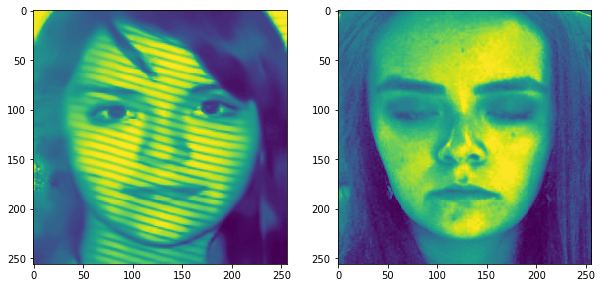

In [29]:
plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(X_test[3][0])
plt.subplot(122),plt.imshow(X_test[3][1])
plt.show()

In [30]:
funcs = [
    lambda x: lbp_features(x, hdiv=3, vdiv=3, mapping='nri_uniform'),
    lambda x: haralick_features(x),
    lambda x: hog_features(x, v_windows=3, h_windows=3, n_bins=8),
]

In [31]:
X_test_feats_pos = get_features(X_test, funcs)
X_test_feats_neg = get_negative_examples(X_test_feats_pos, 1)

In [32]:
X_test_feats = np.concatenate([X_test_feats_pos, X_test_feats_neg])
X_test_feats.shape

(944, 2, 631)

In [33]:
X_test_feats_young = X_test_feats[:, 0, :]
X_test_feats_old = X_test_feats[:, 1, :]
X_test_feats_young.shape, X_test_feats_old.shape

((944, 631), (944, 631))

In [34]:
X_test_feats_young_pca = np.matmul(X_test_feats_young - Xm_young, A_young)
X_test_feats_old_pca = np.matmul(X_test_feats_old - Xm_old, A_old)

In [35]:
X_test_final = np.concatenate([X_test_feats_young_pca, X_test_feats_old_pca], axis=1)
X_test_final.shape

(944, 40)

In [36]:
X_test_final = X_test_final * a + b   

In [37]:
y_pos = np.ones(X_test_feats_pos.shape[0])
y_neg = np.zeros(X_test_feats_neg.shape[0])
y = np.concatenate([y_pos, y_neg])
y.shape

(944,)

In [38]:
y_pred_test = clf.predict(X_test_final)

In [39]:
print(classification_report(y, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.62      0.60      0.61       472
         1.0       0.61      0.64      0.63       472

    accuracy                           0.62       944
   macro avg       0.62      0.62      0.62       944
weighted avg       0.62      0.62      0.62       944



In [40]:
clf.score(X_test_final, y)

0.6186440677966102